In [1]:
import os
import sys

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import Constraint

from tqdm import tqdm_notebook as tqdm

import math

POWER_ITERATIONS = 1
AUTOTUNE = tf.data.experimental.AUTOTUNE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# process data

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def process_path(file_path):
    # label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img


def show_batch(image_batch, labels=None):
    plt.figure(figsize=(10, 10))
    for n in range(min(25, image_batch.shape[0])):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        try:
            plt.title(labels[n])
        except:
            pass
        plt.axis('off')

In [4]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    # ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [5]:
class AdaIN(Model):
    def __init__(self, feat_dim, z_dim):
        super().__init__()
        self.z_proj = Dense(
            units=feat_dim * 2,
            input_shape=(z_dim,),
            activation='relu',
            use_bias=True,            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        
    def call(self, features, z):
        """
        Adaptive instance normalization component. Works with both 4D and 5D tensors
        :features: features to be normalized
        :scale: scaling factor. This would otherwise be calculated as the sigma from a "style" features in style transfer
        :bias: bias factor. This would otherwise be calculated as the mean from a "style" features in style transfer
        """
        scale, bias = tf.split(self.z_proj(z), 2, num=2, axis=1)
        mean, variance = tf.nn.moments(features, list(range(len(features.get_shape())))[1:-1],
                                       keepdims=True)  # Only consider spatial dimension
        sigma = tf.math.rsqrt(variance + 1e-8)
        normalized = (features - mean) * sigma
        scale_broadcast = tf.reshape(scale, tf.shape(mean))
        bias_broadcast = tf.reshape(bias, tf.shape(mean))
        normalized = scale_broadcast * normalized
        normalized += bias_broadcast
        return normalized

In [6]:
class ObjectGenerator(Model):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.w = tf.Variable(tf.random.normal((4, 4, 4, w_dim), stddev=0.02), trainable=True)
        self.adain0 = AdaIN(w_dim, z_dim)
        
        self.deconv1 = K.layers.Conv3DTranspose(
            filters=128,
            kernel_size=(3, 3, 3),
            strides=(2, 2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.adain1 = AdaIN(128, z_dim)
        
        self.deconv2 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(2, 2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.adain2 = AdaIN(64, z_dim)
        
        self.proj1 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(1, 1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.proj2 = K.layers.Conv3DTranspose(
            filters=64,
            kernel_size=(3, 3, 3),
            strides=(1, 1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        
    def call(self, z, view_in=None):
        '''
        w: (bsz, num_objs, height, width, depth, channels)
        z: (bsz, num_objs, z_dim)
        view_in: (bsz, num_objs, 6)
        '''
        if len(z.shape) == 3:
            bsz, num_objs, z_dim = z.shape
            z = tf.reshape(z, (bsz * num_objs, z_dim))
        else:
            bsz, z_dim = z.shape
            num_objs = 1
        w = tf.repeat(tf.expand_dims(self.w, 0), bsz * num_objs, axis=0, name='w')
        
        h0 = self.adain0(w, z)
        h0 = self.lrelu(h0)
        
        h1 = self.deconv1(h0)
        h1 = self.adain1(h1, z)
        h1 = self.lrelu(h1)
        
        h2 = self.deconv2(h1)
        h2 = self.adain2(h2, z)
        h2 = self.lrelu(h2)
        
        ## TODO 3d transform
        # 3d_transform
        ## 
        
        # TEMP replace learnable projection with
        # a transformation
        h2_proj1 = self.proj1(h2)
        h2_proj1 = self.lrelu(h2_proj1)
        
        h2_proj2 = self.proj2(h2_proj1)
        h2_proj2 = self.lrelu(h2_proj2)
        
        return tf.reshape(h2_proj2, (bsz, num_objs, *h2_proj2.shape[1:]))

class Generator(Model):
    def __init__(self, z_dim_bg=30, z_dim_fg=90):
        super().__init__()
        
        self.z_dim_bg = z_dim_bg
        self.z_dim_fg = z_dim_fg
        # self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        self.bg_generator = ObjectGenerator(z_dim_bg, 256)
        self.fg_generator = ObjectGenerator(z_dim_fg, 512)
        
        self.deconv3 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(1, 1),
            strides=(1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv4 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv5 = K.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        self.deconv6 = K.layers.Conv2DTranspose(
            filters=3,
            kernel_size=(4, 4),
            strides=(1, 1),
            padding='same',
            kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
            bias_initializer='zeros',
        )
        #self.deconv7 = K.layers.Conv2DTranspose(
        #    filters=3,
        #    kernel_size=(4, 4),
        #    strides=(1, 1),
        #    padding='same',
        #    kernel_initializer=tf.initializers.RandomNormal(stddev=0.02),
        #    bias_initializer='zeros',
        #)
        
    def call(self, z_bg, z_fg):
        bsz = z_bg.shape[0]
        # z_bg = tf.random.uniform((bsz, self.z_dim_bg), minval=0, maxval=1, dtype=tf.float32)
        # z_fg = tf.random.uniform((bsz, self.z_dim_fg), minval=0, maxval=1, dtype=tf.float32)
        
        bg = self.bg_generator(z_bg, None)
        fg = self.fg_generator(z_fg, None)
        
        # bg = tf.expand_dims(bg, 1)
        # fg = tf.expand_dims(fg, 1)
        
        composed_scene = tf.concat((bg, fg), axis=1)
        composed_scene = tf.math.reduce_max(composed_scene, axis=1, name='composed_scene')
        
        h2_2d = tf.reshape(composed_scene, (bsz, 16, 16, 16 * 64))
        
        h3 = self.lrelu(self.deconv3(h2_2d))
        h4 = self.lrelu(self.deconv4(h3))
        h5 = self.lrelu(self.deconv5(h4))
        h6 = tf.math.tanh(self.deconv6(h5))
        # h6 = self.lrelu(self.deconv6(h5))
        # h7 = tf.math.sigmoid(self.deconv7(h6))
        
        return h6

In [7]:
# discriminator 
def l2_normalize(x, eps=1e-12):
    '''
  Scale input by the inverse of it's euclidean norm
  '''
    return x / tf.linalg.norm(x + eps)


class Spectral_Norm(Constraint):
    '''
    Uses power iteration method to calculate a fast approximation 
    of the spectral norm (Golub & Van der Vorst)
    The weights are then scaled by the inverse of the spectral norm
    '''
    def __init__(self, power_iters=POWER_ITERATIONS):
        self.n_iters = power_iters

    def __call__(self, w):
        flattened_w = tf.reshape(w, [w.shape[0], -1])
        u = tf.random.normal([flattened_w.shape[0]])
        v = tf.random.normal([flattened_w.shape[1]])
        for i in range(self.n_iters):
            v = tf.linalg.matvec(tf.transpose(flattened_w), u)
            v = l2_normalize(v)
            u = tf.linalg.matvec(flattened_w, v)
            u = l2_normalize(u)
        sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
        return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

class InstanceNorm(Model):
    def __init__(self, num_channels):
        super().__init__()
        self.scale = tf.Variable(initial_value=tf.random.normal((num_channels,), 1.0, 0.02))
        self.offset = tf.Variable(initial_value=tf.zeros((num_channels,), dtype=tf.float32))
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        epsilon = 1e-5
        inv = tf.math.rsqrt(variance + epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        
        self.lrelu = K.layers.LeakyReLU(alpha=0.2)
        
        self.conv0 = Conv2D(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            # kernel_constraint=Spectral_Norm(),
        )
        
        self.conv1 = Conv2D(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm1 = InstanceNorm(128)
        
        self.conv2 = Conv2D(
            filters=256,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm2 = InstanceNorm(256)
        
        self.conv3 = Conv2D(
            filters=512,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            kernel_initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            kernel_constraint=Spectral_Norm(),
        )
        self.inst_norm3 = InstanceNorm(512)
        
        self.linear = Dense(1, kernel_constraint=Spectral_Norm())

    def call(self, x):
        
        x = self.lrelu(self.conv0(x))
        x = self.lrelu(self.inst_norm1(self.conv1(x)))
        x = self.lrelu(self.inst_norm2(self.conv2(x)))
        x = self.lrelu(self.inst_norm3(self.conv3(x)))
        
        return self.linear(tf.reshape(x, (-1, 4 * 4 * 512)))

In [8]:
# lossess
def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)

    generated_loss = bce(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [9]:
train_dir = os.path.join('/home/samenabar/datasets/CLEVR_v1.0/images/train/')
validation_dir = os.path.join('/home/samenabar/datasets/CLEVR_v1.0/images/val/')

In [10]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))

print('num_tr', num_tr)
print('num_val', num_val)

BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64

num_tr 70000
num_val 15000


In [11]:
list_ds_train = tf.data.Dataset.list_files(os.path.join(train_dir, '*.png'))
labeled_ds = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)

for image in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (64, 64, 3)


In [12]:
train_ds = prepare_for_training(labeled_ds)
# for _ in tqdm(train_ds, total=int(math.ceil(num_tr / BATCH_SIZE))):
#     pass

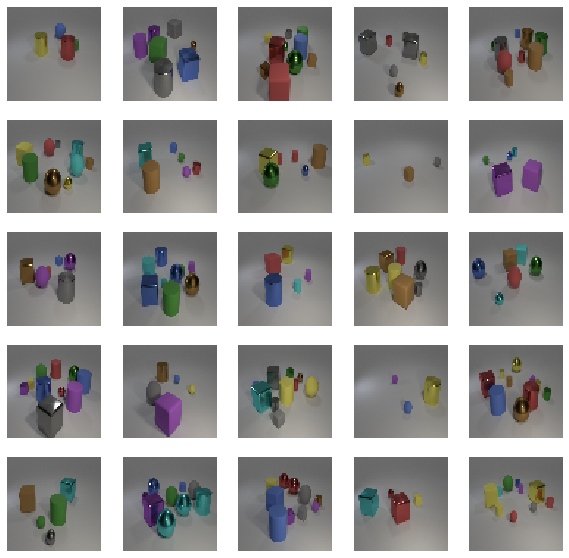

In [13]:
image_batch = next(iter(train_ds))
show_batch(image_batch.numpy())

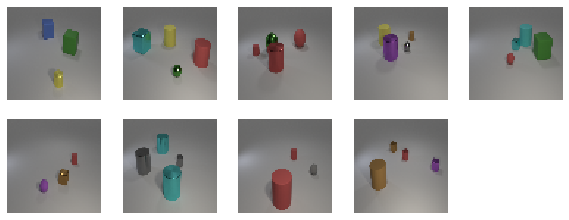

In [36]:
selected_batch = tf.gather(image_batch, [3, 5, 6, 7, 9, 11, 12, 14, 23])
show_batch(selected_batch)

In [75]:
z_bg = tf.random.uniform((selected_batch.shape[0], generator.z_dim_bg), minval=-1, maxval=1)

num_objs = [3, 4, 4, 4, 4, 3, 4, 3, 4]
tensors = []
max_len = max(num_objs)
for no in num_objs:
    _t = tf.random.uniform((no, generator.z_dim_fg), minval=-1, maxval=1)
    _z = tf.zeros((max_len - no, generator.z_dim_fg), dtype=tf.float32)
    _t = tf.concat((_t, _z), axis=0)
    tensors.append(_t)
z_fg = tf.stack(tensors, axis=0)

In [82]:
### OVERFIT TO DATA

generator = Generator()
discriminator = Discriminator()

total_g_loss = 0.
total_d_loss = 0.

bce = K.losses.BinaryCrossentropy(from_logits=True)

num_steps = 1000
pbar = tqdm(range(num_steps), total=num_steps)

for it in pbar:

    with tf.GradientTape(persistent=True) as tape:
        generated = generator(z_bg, z_fg)

        d_fake_logits = discriminator(generated)
        real_input = ((selected_batch * 2) - 1) + tf.random.normal(selected_batch.shape, stddev=.02)
        d_real_logits = discriminator(real_input)

        d_loss = discriminator_loss(d_real_logits, d_fake_logits)
        g_loss = generator_loss(d_fake_logits)

    d_variables = discriminator.trainable_variables
    d_gradients = tape.gradient(d_loss, d_variables)
    discriminator_optimizer.apply_gradients(zip(d_gradients, d_variables))

    g_variables = generator.trainable_variables
    g_gradients = tape.gradient(g_loss, g_variables)
    generator_optimizer.apply_gradients(zip(g_gradients, g_variables))

    total_d_loss += d_loss.numpy()
    total_g_loss += g_loss.numpy()

    pbar.set_postfix(g_loss=f'{g_loss.numpy():.4f} ({total_g_loss / (it + 1):.4f})',
                     d_loss=f'{d_loss.numpy():.4f} ({total_d_loss / (it + 1):.4f})')
    # break

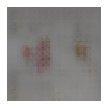

In [110]:
_generated = generator(
    tf.random.uniform((1, 30), minval=-1, maxval=1),
    tf.random.uniform((1, 2, 90), minval=-1, maxval=1),
)
show_batch((_generated + 1) / 2)

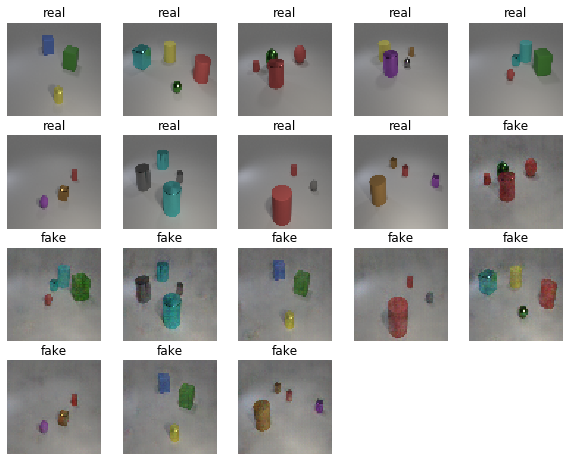

In [93]:
show_batch(tf.concat((selected_batch, (generated + 1) / 2), axis=0), labels=['real'] * 9 + ['fake'] * 9)

In [114]:
tf.random.uniform((64,),minval=3, maxval=min(10, 5 + 2 * 0), dtype=tf.int32)

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 4, 3, 3, 3,
       4, 3, 3, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4],
      dtype=int32)>

In [14]:
import datetime

In [27]:
log_dir = "HoloGAN/log/" + datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")
summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
### TRAIN ON DATASET

# LOGGING

# generator = Generator()
# discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999)

bce = K.losses.BinaryCrossentropy(from_logits=True)

# num_steps = 1000
# pbar = tqdm(enumerate(train_ds), total=num_tr // BATCH_SIZE)

total_g_loss = 0.
total_d_loss = 0.

with summary_writer.as_default():
    total_it = 0
    total_g_loss = 0.
    total_d_loss = 0.
    counter = 1
    
    for epoch in range(25):
        train_ds = prepare_for_training(labeled_ds)
        pbar = tqdm(enumerate(train_ds), total=int(math.ceil(num_tr / BATCH_SIZE)))

        for it, image_batch in pbar:
            bsz = image_batch.shape[0]

            with tf.GradientTape(persistent=True) as tape:
                # generated random noise
                z_bg = tf.random.uniform((bsz, generator.z_dim_bg), minval=-1, maxval=1)
                num_objs = tf.random.uniform((bsz,), minval=3, maxval=min(10, 5 + 2 * epoch), dtype=tf.int32)
                tensors = []
                max_len = max(num_objs)
                for no in num_objs:
                    _t = tf.random.uniform((no, generator.z_dim_fg), minval=-1, maxval=1)
                    _z = tf.zeros((max_len - no, generator.z_dim_fg), dtype=tf.float32)
                    _t = tf.concat((_t, _z), axis=0)
                    tensors.append(_t)
                z_fg = tf.stack(tensors, axis=0)

                # fake img
                generated = generator(z_bg, z_fg)

                d_fake_logits = discriminator(generated)
                d_real_logits = discriminator(((image_batch * 2) - 1) + tf.random.normal(image_batch.shape, stddev=.02))

                d_loss = discriminator_loss(d_real_logits, d_fake_logits)
                g_loss = generator_loss(d_fake_logits)

            d_variables = discriminator.trainable_variables
            d_gradients = tape.gradient(d_loss, d_variables)
            discriminator_optimizer.apply_gradients(zip(d_gradients, d_variables))

            g_variables = generator.trainable_variables
            g_gradients = tape.gradient(g_loss, g_variables)
            generator_optimizer.apply_gradients(zip(g_gradients, g_variables))

            total_d_loss += d_loss.numpy()
            total_g_loss += g_loss.numpy()

            pbar.set_postfix(g_loss=f'{g_loss.numpy():.4f} ({total_g_loss / (counter):.4f})',
                             d_loss=f'{d_loss.numpy():.4f} ({total_d_loss / (counter):.4f})')

            if total_it % 100 == 0:
                print('AAAH')
                tf.summary.scalar('losses/d_loss', total_d_loss / counter, step=total_it + 1)
                tf.summary.scalar('losses/g_loss', total_g_loss / counter, step=total_it + 1)
                tf.summary.image(f'generated_{epoch}-{it}.jpg', (generated + 1) / 2, step=total_it, max_outputs=8)
                
                total_g_loss = 0.
                total_d_loss = 0.
                counter = 1
                tf.summary.flush()
                
            total_it += 1
            counter += 1

            # break

AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH
AAAH



AAAH
AAAH
AAAH
AAAH


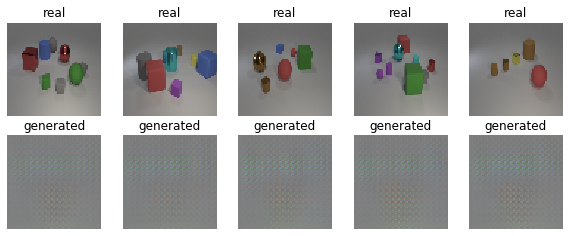

In [18]:
show_batch(tf.concat((image_batch[:5], (generated[:5] + 1.) / 2), axis=0), ['real'] * 5 + ['generated'] * 5)

In [108]:
iter(train_ds).__dict__

{'_device': '',
 '_dataset': <_ModelDataset shapes: (None, 64, 64, 3), types: tf.float32>,
 '_element_spec': TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
 '_flat_output_types': [tf.float32],
 '_flat_output_shapes': [TensorShape([None, 64, 64, 3])],
 '_iterator_resource': <tf.Tensor: shape=(), dtype=resource, numpy=<unprintable>>,
 '_deleter': <tf.Tensor: shape=(), dtype=variant, numpy=<unprintable>>,
 '_resource_deleter': <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter at 0x7f3e23015048>}

In [119]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.
